In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def rk4(f, trange, h, x0, u):
    if type(u) in [int, float]:
        u = np.array([[u]])
    rk_coef = np.array([1, 2, 2, 1], dtype=float)
    t = np.arange(trange[0], trange[1], h)
    xt = np.empty((len(t), len(x0), 1), dtype=float)
    xt[0,:,:]=x0
    k=np.empty((len(x0),4,1), dtype=float)
    for step, current_t in enumerate(t[:-1]):
        k[:,0,:] = f(current_t, xt[step], u)
        k[:,1,:] = f(current_t + (h/2), xt[step] + ((h/2)*k[:,0,:]), u)
        k[:,2,:] = f(current_t + (h/2), xt[step] + ((h/2)*k[:,1,:]), u)
        k[:,3,:] = f(current_t, xt[step] + (h*k[:,2,:]), u)
        final_diff = (rk_coef*np.squeeze(k)).sum(axis=1).reshape(-1,1)
        xt[step+1] = xt[step] + ((h/6)*final_diff)
    return t, xt

In [3]:
def plot(t, xt):
    fig, ax = plt.subplots(1,1, figsize=(16,9))
    ax.grid()
    for i in range(xt.shape[1]):
        ax.plot(t, xt[:,i], label=rf'$x_{i}$')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Signal')
    ax.legend()
    return fig, ax

In [4]:
kp = 6.25
ki=kp
c0=5
c1=6
A = np.array([
    [0,-1,0],
    [0, 0, 1],
    [ki, (-c0-kp), -c1]
])
B = np.array([
    [1],
    [0],
    [kp]
])
C = np.array([[0,1,0]])
D = np.array([[0]])

def dynamical_sys(t,x,u):
    dx = A@x + B@u
    return dx

A, B, C, D

(array([[  0.  ,  -1.  ,   0.  ],
        [  0.  ,   0.  ,   1.  ],
        [  6.25, -11.25,  -6.  ]]),
 array([[1.  ],
        [0.  ],
        [6.25]]),
 array([[0, 1, 0]]),
 array([[0]]))

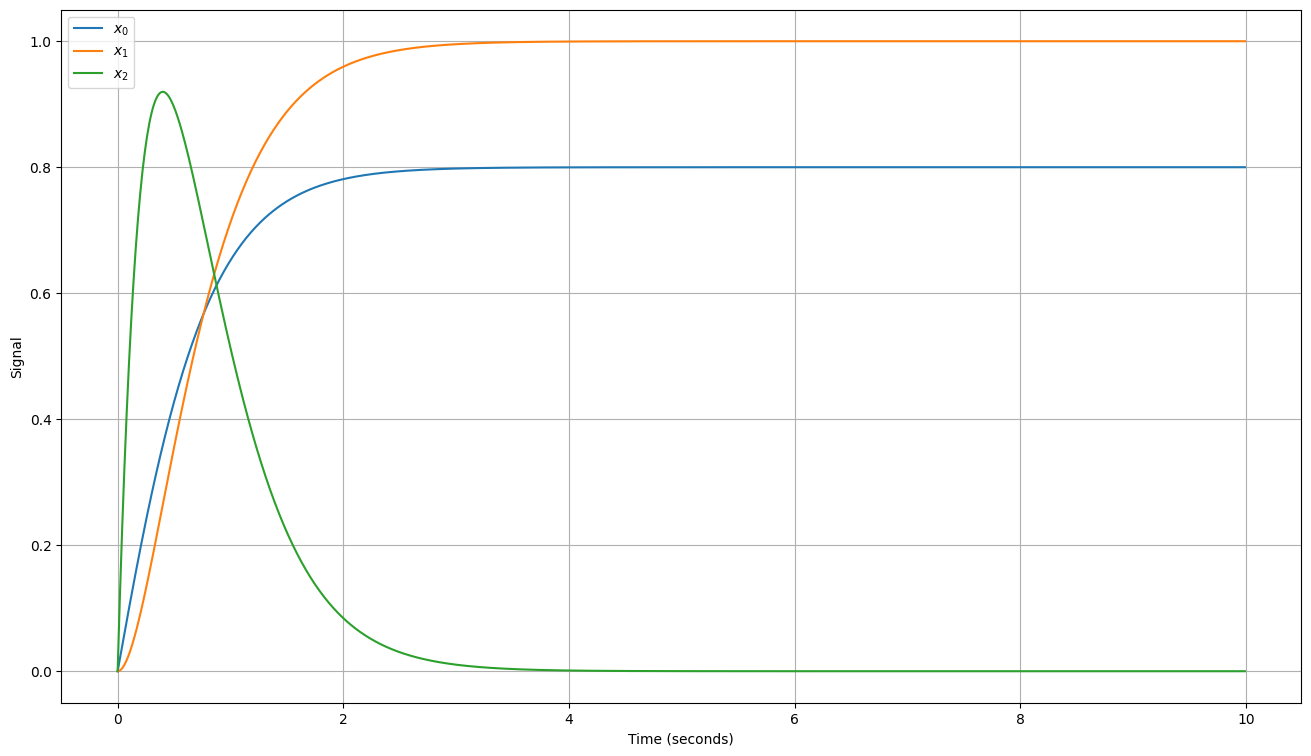

In [5]:
h=0.01
trange=[0,10]
x0=np.array([0,0,0]).reshape(-1,1)
ref=1
t, xt = rk4(dynamical_sys, trange, h, x0, ref)
_, _ = plot(t, xt)